# **DSCI 100 Group Project**
Authors: 
- Munn Chai
- Deep Shah
- Your name here
- Your name here

### **Introduction**
info needed:
- context, background info about topic
- state question clearly
- identify dataset that will be used

### **Preliminary Exploratory Data Analysis**
info needed: 
- read dataset into R
- wrangle data into tidy data
- using Training data only, summarize the data in one table. An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
- Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

### **Methods**
info needed: 
- explain how you will conduct your data analysis, and which rows and columns you will use
- describe one way you will visualize the results

### **Expected Outcomes and Significance**
info needed: 
- what do you expect to find?
- what impact do these findings have? 
- what future questions could these findings lead to? 

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
speed_dating_data <- read_csv("http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/Speed%20Dating%20Data.csv")

Rows: 8378 Columns: 195
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): field, undergra, from, career
dbl (187): iid, id, gender, idg, condtn, wave, round, position, positin1, or...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
speed_dating_tidy <- speed_dating_data |>
    filter(wave != 6:9) |> # these waves had a different rating system for traits
    select(match, gender, date, attr1_1, sinc1_1, intel1_1, fun1_1, amb1_1) |>
    mutate(match = as_factor(match)) |>
    na.omit()

# speed_dating_tidy <- speed_dating_data |>
#     filter(wave != 6:9) |> # these waves had a different rating system for traits
#     select(match, gender, date, attr1_1, sinc1_1, intel1_1, fun1_1, amb1_1,
#           attr2_1, sinc2_1, intel2_1, fun2_1, amb2_1, 
#           attr3_1, sinc3_1, intel3_1, fun3_1, amb3_1,
#           attr4_1, sinc4_1, intel4_1, fun4_1, amb4_1,
#           attr5_1, sinc5_1, intel5_1, fun5_1, amb5_1) |>
#     mutate(match = as_factor(match)) |>
#     na.omit()

Warning message in wave != 6:9:
“longer object length is not a multiple of shorter object length”


In [8]:
# keeping results consistent
set.seed(100)

speed_dating_split <- initial_split(speed_dating_tidy, prop = 0.75, strata = match)  
speed_dating_train <- training(speed_dating_split)   
speed_dating_test <- testing(speed_dating_split) 
nrow(speed_dating_tidy)
nrow(speed_dating_train)
nrow(speed_dating_test)

[1] 7872

[1] 5903

[1] 1969

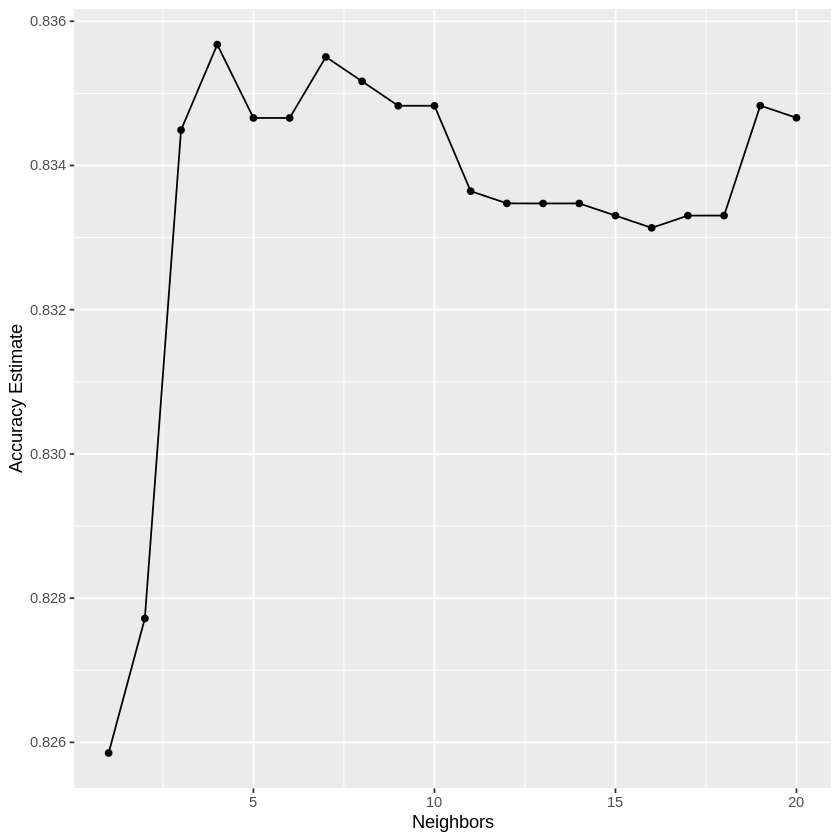

In [9]:
set.seed(100)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

speed_dating_vfold <- vfold_cv(data = speed_dating_train, v = 5, strata = match)

k_value <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

speed_dating_recipe <- recipe(match ~ ., data = speed_dating_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_results <- workflow() |>
    add_recipe(speed_dating_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = speed_dating_vfold, grid = k_value) |>
    collect_metrics() 

accuracies <- knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate")
cross_val_plot

In [10]:
knn_nine <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |> # work out good number of k? for some reason the cross validation is not working very well
    set_engine("kknn") |>
    set_mode("classification")

dating_fit <- workflow() |>
    add_recipe(speed_dating_recipe) |>
    add_model(knn_nine) |>
    fit(data = speed_dating_test)

predictions <- predict(dating_fit, speed_dating_test) |>
    bind_cols(speed_dating_test)

match_prediction_accuracy <- predictions |>
        metrics(truth = match, estimate = .pred_class)
match_prediction_accuracy

match_prediction_conf_mat <- predictions |>
        conf_mat(truth = match, estimate = .pred_class)
match_prediction_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8501778
kap,binary,0.2596678


          Truth
Prediction    0    1
         0 1604  254
         1   41   70

###### 